# Constructing an Iris mesh from bare numbers

In [11]:
# Construct a test mesh from scratch : define a mesh in numbers

# define some node X and Y points
import numpy as np
big_points_x = np.array([6.0, 3, 5, 1, 5, 3, 5, 5, 4, 2, 1, 6, 3, 5, 3, 6, 2, 6, 1, 2, 2, 4, 1, 4, 4, 3, 4, 6, 2, 1])
big_points_y = np.array([2.5, 1, 3, 0, 2, 0, 0, 4, 3.5, 2.5, 1, 4.5, 4, 1, 3, 3.5, 0.5, 0.5, 3, 4.5, 1.5, 2.5, 4, 1.5, 4.5, 2, 0.5, 1.5, 3.5, 2])

big_points = np.stack([big_points_x, big_points_y]).T

big_data = 100 * np.random.rand(30)

# define which faces use which points
big_faces = [
    [22, 28, 19],
    [18, 28, 22],
    [18, 9, 28],
    [9, 18, 29],
    [29, 20, 9],
    [10, 20, 29],
    [10, 16, 20],
    [3, 16, 10],
    [19, 25, 24],
    [16, 25, 19],
    [16, 5, 25],
    [5, 24, 25],
    [5, 17, 24],
    [17, 11, 24],
]
face_count = len(big_faces)

big_face_plottable_x = []
big_face_plottable_y = []

for face in big_faces:
    big_face_plottable_x.append([])
    big_face_plottable_y.append([])
    for node_num in face:
        big_face_plottable_x[-1].append(big_points_x[node_num])
        big_face_plottable_y[-1].append(big_points_y[node_num])
    big_face_plottable_x[-1].append(big_points_x[face[0]])
    big_face_plottable_y[-1].append(big_points_y[face[0]])

    
# Calculate coordinates of locations in the "middle" of each face
# N.B. except, means of lats + lons are not true centres !
face_coordinates_x = [np.mean(xs) for xs in big_face_plottable_x]
face_coordinates_y = [np.mean(ys) for ys in big_face_plottable_y]

# Calculate some random data for the cube 'payload'.
np.random.seed(seed=1234)
big_face_data = np.random.uniform(0, 100, face_count)

In [12]:
# Create the component coordinates and connectivities.

import iris.experimental.ugrid
from iris.coords import AuxCoord

# node coordinates
node_coords_and_axes = [
    (AuxCoord(big_points_x, standard_name="longitude"), "x"),
    (AuxCoord(big_points_y, standard_name="latitude"), "y"),
]

# face_node_connectivity
face_connectivity = iris.experimental.ugrid.mesh.Connectivity(
    big_faces,
    cf_role = 'face_node_connectivity'
)

# face coordinates
face_coords_and_axes = [
    (AuxCoord(face_coordinates_x, standard_name="longitude"), "x"),
    (AuxCoord(face_coordinates_y, standard_name="latitude"), "y"),
]

In [13]:
# Make a mesh by passing the coordinates + connectivities
# N.B. it's pretty unusual to be calling this directly, but the API does exist

from iris.experimental.ugrid.mesh import Mesh

my_first_mesh = iris.experimental.ugrid.Mesh(
    topology_dimension=2,
    node_coords_and_axes=node_coords_and_axes,
    connectivities=[face_connectivity],
    face_coords_and_axes=face_coords_and_axes
)
print(my_first_mesh)

Mesh : 'unknown'
    topology_dimension: 2
    node
        node_dimension: 'Mesh2d_node'
        node coordinates
            <AuxCoord: longitude / (unknown)  [...]  shape(30,)>
            <AuxCoord: latitude / (unknown)  [...]  shape(30,)>
    face
        face_dimension: 'Mesh2d_face'
        face_node_connectivity: <Connectivity: unknown / (unknown)  [...]  shape(14, 3)>
        face coordinates
            <AuxCoord: longitude / (unknown)  [...]  shape(14,)>
            <AuxCoord: latitude / (unknown)  [...]  shape(14,)>


In [14]:
# Here we make a cube with data attached to **faces**
# N.B. a mesh may be shared by multiple cubes, the cubes may use the same or different locations

from iris.cube import Cube

x_coord = iris.experimental.ugrid.mesh.MeshCoord(my_first_mesh, "face", "x")
y_coord = iris.experimental.ugrid.mesh.MeshCoord(my_first_mesh, "face", "y")

my_first_mesh_cube = iris.cube.Cube(
    data=big_face_data,
    aux_coords_and_dims=[
        (x_coord, 0),
        (y_coord, 0),
    ]
)

my_first_mesh_cube

Unknown (unknown),--
Shape,14
Mesh coordinates,
latitude,x
longitude,x
Mesh,
name,unknown
location,face


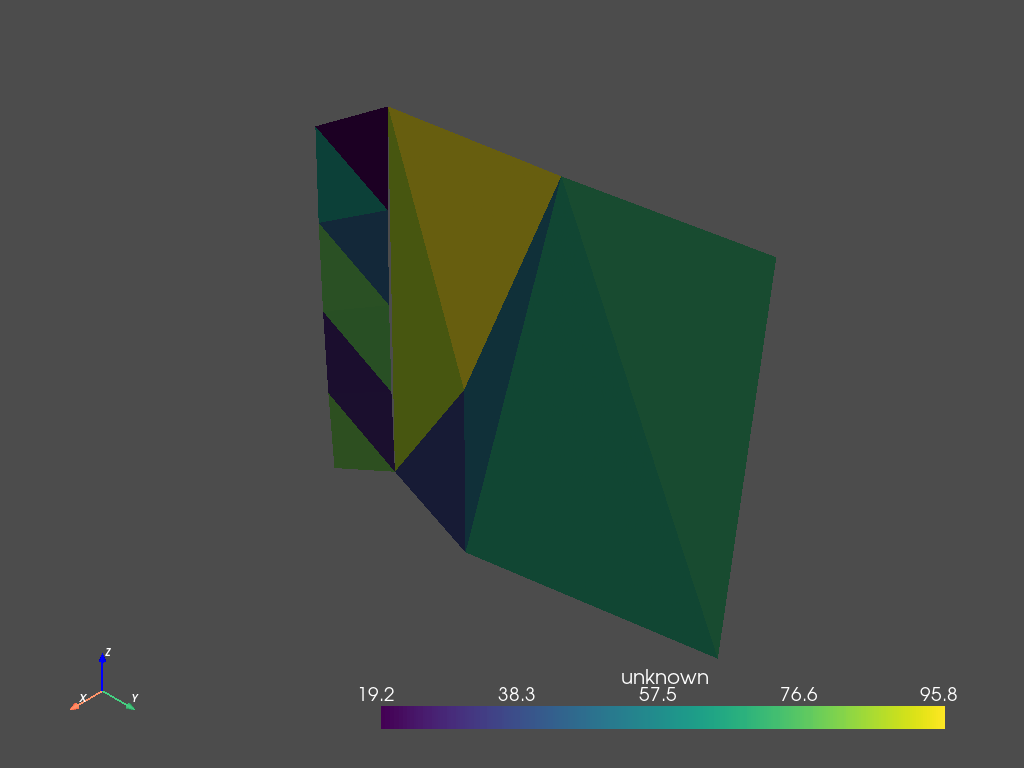

In [15]:
# Assign some data to the cube, convert to a PolyData and plot it

from pv_conversions import pv_from_lfric_cube
pv = pv_from_lfric_cube(my_first_mesh_cube)
pv.plot(jupyter_backend='static')